In [1]:
from bitarray import bitarray
import random
import numpy as np
import math
import timeit

In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K

/Users/aditijain/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/aditijain/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/aditijain/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/aditijain/opt/anaconda3/lib/python3.7/site-packages

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix

In [4]:
import pandas as pd
import os

In [5]:
from sklearn import datasets

In [6]:
bcancer = datasets.load_breast_cancer()
X = bcancer.data  
y = bcancer.target
X = StandardScaler().fit_transform(X)

In [7]:
x_neg=X[y==0]
x_pos=X[y==1]
y_pos=y[y==1]
y_neg=y[y==0]
np.random.shuffle(x_neg)
print(x_neg.shape)
print(x_pos.shape)

(212, 30)
(357, 30)


In [8]:
indices=np.arange(106)
#x_train=np.array(x_neg[0:106])[indices]
y_train=y_neg[0:106]
x_train=np.concatenate((np.array(x_neg[0:106])[indices],x_pos)).reshape(-1,30)
y_train=np.concatenate((y_train,y_pos)).reshape(-1,1)

In [9]:
x_test = x_neg[106:212].reshape(-1,30)
y_test = y_neg[106:212].reshape(-1,1)

# Standard Bloom Filter

In [10]:
from bitarray import bitarray
import mmh3
import random
import numpy as np
import math

In [11]:
class BloomFilter:
    
    def __init__(self, size, hash_count):
        self.size = size
        self.hash_count = hash_count
        self.bit_array = bitarray(size)
        self.bit_array.setall(0)
        
    def add(self, num):
        for seed in range(1,self.hash_count+1):
            result = mmh3.hash(str(num), seed) % self.size
            self.bit_array[result] = 1
            
    def lookup(self, num):
        for seed in range(1,self.hash_count+1):
            result = mmh3.hash(str(num), seed) % self.size
            if self.bit_array[result] == 0:
                return False
        return True

# Projection model

In [12]:
class Projection_BloomFilter:
    def __init__(self, size, hash_count, dim):
        vectors = np.random.normal(0,1,size=(hash_count,dim)) #random vectors(each row) from normal distribution, not unit vectors
        i=0
        while(i<hash_count):
            if(vectors[i][0]<0):
                vectors[i][0] *= -1
               # print("initial v", vectors[i])
                #vectors[i]=np.random.normal(0,1,size=(1,dim))
                #print("changed v", vectors[i])
            i = i+1
       # print(vectors)        
        self.unit_vectors = np.transpose(vectors/np.sqrt(np.transpose([np.sum(np.multiply(vectors,vectors),1)]))) #Matrix where each column is a unit vector, used as hash
        self.size = size
        self.hash_count = hash_count
        self.bit_array = bitarray(size)
        self.bit_array.setall(0)

    def give_hash_values(self,X):
        projections = np.dot(X,self.unit_vectors) #Projections of datapoints on unit vectors
        norm_proj = 1/(1+np.exp(-projections)) #Sigmoid on each value so that they are in the range (0,1)
        hash_values = (norm_proj*(self.size-1)).astype(int) #All values are integers in the range [0,size-1]
        return hash_values                        #Each row contains hash values of that datapoint

    def add(self,x):
        hash_values = self.give_hash_values(x)
        for i in hash_values:
            self.bit_array[i] = 1
        
    def bulk_add(self, X):
        hash_values = self.give_hash_values(X)
        for i in hash_values:
            for j in i:
                self.bit_array[j] = 1
            
    def lookup(self, x):
        hash_values = self.give_hash_values(x)
        for i in hash_values:
            if(self.bit_array[i]==0):
                return False
        return True

    
#(Input:bloom filter,normalized positive data,normalized negative data; Output:(-1) for false negative, otherwise fpr)
def find_fpr(bf,x_pos,x_neg):
    fp = 0
    tn = 0
    pos_hash_values = bf.give_hash_values(x_pos)
    neg_hash_values = bf.give_hash_values(x_neg)
    for i in pos_hash_values:
        for j in i:
            if(bf.bit_array[j]==0):
                return -1
    for i in neg_hash_values:
        flag = 0
        for j in i:
            if(bf.bit_array[j]==0):
                tn += 1 
                flag = 1           
                break
        if(flag==0):
            fp += 1
    return fp/(fp+tn)

def find_fpr2(bf,x_neg):
    fp = 0
    tn = 0
    neg_hash_values = bf.give_hash_values(x_neg)
    for i in neg_hash_values:
        flag = 0
        for j in i:
            if(bf.bit_array[j]==0):
                tn += 1 
                flag = 1           
                break
        if(flag==0):
            fp += 1
    return fp/(fp+tn)

#(Input:bloom filter size, total random numbers, ratio of number inserted; Output:efficient number of hash functions)
def eff_k(m,n,r):
    k=int(m/(int(n*r))*math.log(2))
    if(k==0):
        return 1
    return k

In [13]:
def get_data_points_Projection(x_train,x_test,y_train,init_size,diff,num,epochs,fpr_values,size_values,times,standard_times):
    input_dim = x_train.shape[1]
    n = sum(y_train)
    x_pos = x_train[(y_train==1).reshape(-1)]
    print(x_pos.shape)
    x_neg = x_train[(y_train==0).reshape(-1)]
    for i in range(0,num):
        m = init_size + i*diff
        k = eff_k(m,n,1)
        fpr = 1
        start1 = timeit.default_timer()
        
        stanbf = BloomFilter(m,k)
        for x_pos_i in x_pos:
            stanbf.add(sum(x_pos_i))
        
        stop1 = timeit.default_timer()
        
        start = timeit.default_timer()
        tempbf = Projection_BloomFilter(m,k,input_dim)
        for j in range(0,epochs):
            bf = Projection_BloomFilter(m,k,input_dim)
            bf.bulk_add(x_pos)
            temp = find_fpr(bf,x_pos,x_neg)
            if(fpr>=temp):
                fpr = temp
                tempbf=bf
        stop = timeit.default_timer()
        fpr_test=find_fpr2(tempbf,x_test)
        print("Size: %d Bits - FPR: %f - Time Taken to create Standard: %f - Time Taken to create Projecion: %f \n\n\n" % (m,fpr_test,stop1-start1,stop-start))
        fpr_values += [fpr_test]
        size_values += [m]
        times += [stop-start]
        standard_times += [stop1-start1]

In [14]:
num_of_iterations = 5#Increase to make graph smoother

fpr_values = []
size_values = []
times = []
standard_times = []

for i in range(0,num_of_iterations):
    print("~~~~~~~~ Iteration %d ~~~~~~~~ \n" %(i+1))
    get_data_points_Projection(x_train,x_test,y_train,10,10,300,100,fpr_values,size_values,times,standard_times)

~~~~~~~~ Iteration 1 ~~~~~~~~ 

(357, 30)
Size: 10 Bits - FPR: 0.311321 - Time Taken to create Standard: 0.003328 - Time Taken to create Projecion: 0.279084 



Size: 20 Bits - FPR: 0.452830 - Time Taken to create Standard: 0.003875 - Time Taken to create Projecion: 0.242433 



Size: 30 Bits - FPR: 0.339623 - Time Taken to create Standard: 0.007434 - Time Taken to create Projecion: 0.212526 



Size: 40 Bits - FPR: 0.283019 - Time Taken to create Standard: 0.004049 - Time Taken to create Projecion: 0.212213 



Size: 50 Bits - FPR: 0.358491 - Time Taken to create Standard: 0.004847 - Time Taken to create Projecion: 0.290663 



Size: 60 Bits - FPR: 0.150943 - Time Taken to create Standard: 0.014710 - Time Taken to create Projecion: 0.198821 



Size: 70 Bits - FPR: 0.254717 - Time Taken to create Standard: 0.007932 - Time Taken to create Projecion: 0.416119 



Size: 80 Bits - FPR: 0.179245 - Time Taken to create Standard: 0.009285 - Time Taken to create Projecion: 0.349516 



Size: 

Size: 690 Bits - FPR: 0.103774 - Time Taken to create Standard: 0.004014 - Time Taken to create Projecion: 0.372708 



Size: 700 Bits - FPR: 0.056604 - Time Taken to create Standard: 0.004830 - Time Taken to create Projecion: 0.207257 



Size: 710 Bits - FPR: 0.103774 - Time Taken to create Standard: 0.003637 - Time Taken to create Projecion: 0.213984 



Size: 720 Bits - FPR: 0.084906 - Time Taken to create Standard: 0.005798 - Time Taken to create Projecion: 0.189554 



Size: 730 Bits - FPR: 0.122642 - Time Taken to create Standard: 0.004141 - Time Taken to create Projecion: 0.192064 



Size: 740 Bits - FPR: 0.075472 - Time Taken to create Standard: 0.004134 - Time Taken to create Projecion: 0.197321 



Size: 750 Bits - FPR: 0.028302 - Time Taken to create Standard: 0.004160 - Time Taken to create Projecion: 0.195399 



Size: 760 Bits - FPR: 0.047170 - Time Taken to create Standard: 0.004791 - Time Taken to create Projecion: 0.227136 



Size: 770 Bits - FPR: 0.075472 - Time Ta

Size: 1370 Bits - FPR: 0.028302 - Time Taken to create Standard: 0.005312 - Time Taken to create Projecion: 0.249394 



Size: 1380 Bits - FPR: 0.094340 - Time Taken to create Standard: 0.004619 - Time Taken to create Projecion: 0.236532 



Size: 1390 Bits - FPR: 0.066038 - Time Taken to create Standard: 0.005943 - Time Taken to create Projecion: 0.222516 



Size: 1400 Bits - FPR: 0.056604 - Time Taken to create Standard: 0.005554 - Time Taken to create Projecion: 0.206707 



Size: 1410 Bits - FPR: 0.037736 - Time Taken to create Standard: 0.004899 - Time Taken to create Projecion: 0.188302 



Size: 1420 Bits - FPR: 0.056604 - Time Taken to create Standard: 0.004152 - Time Taken to create Projecion: 0.212038 



Size: 1430 Bits - FPR: 0.113208 - Time Taken to create Standard: 0.005017 - Time Taken to create Projecion: 0.198285 



Size: 1440 Bits - FPR: 0.084906 - Time Taken to create Standard: 0.005556 - Time Taken to create Projecion: 0.196345 



Size: 1450 Bits - FPR: 0.056604 

Size: 2050 Bits - FPR: 0.009434 - Time Taken to create Standard: 0.008402 - Time Taken to create Projecion: 0.229709 



Size: 2060 Bits - FPR: 0.066038 - Time Taken to create Standard: 0.007040 - Time Taken to create Projecion: 0.424618 



Size: 2070 Bits - FPR: 0.150943 - Time Taken to create Standard: 0.008305 - Time Taken to create Projecion: 0.254612 



Size: 2080 Bits - FPR: 0.009434 - Time Taken to create Standard: 0.005094 - Time Taken to create Projecion: 0.256842 



Size: 2090 Bits - FPR: 0.037736 - Time Taken to create Standard: 0.007159 - Time Taken to create Projecion: 0.433437 



Size: 2100 Bits - FPR: 0.018868 - Time Taken to create Standard: 0.004345 - Time Taken to create Projecion: 0.269092 



Size: 2110 Bits - FPR: 0.028302 - Time Taken to create Standard: 0.006268 - Time Taken to create Projecion: 0.259668 



Size: 2120 Bits - FPR: 0.028302 - Time Taken to create Standard: 0.009486 - Time Taken to create Projecion: 0.266560 



Size: 2130 Bits - FPR: 0.018868 

Size: 2730 Bits - FPR: 0.018868 - Time Taken to create Standard: 0.011990 - Time Taken to create Projecion: 0.685396 



Size: 2740 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.013129 - Time Taken to create Projecion: 0.555519 



Size: 2750 Bits - FPR: 0.009434 - Time Taken to create Standard: 0.011801 - Time Taken to create Projecion: 0.382172 



Size: 2760 Bits - FPR: 0.028302 - Time Taken to create Standard: 0.007649 - Time Taken to create Projecion: 0.410047 



Size: 2770 Bits - FPR: 0.084906 - Time Taken to create Standard: 0.006906 - Time Taken to create Projecion: 0.400430 



Size: 2780 Bits - FPR: 0.009434 - Time Taken to create Standard: 0.009411 - Time Taken to create Projecion: 0.337873 



Size: 2790 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.004975 - Time Taken to create Projecion: 0.339424 



Size: 2800 Bits - FPR: 0.047170 - Time Taken to create Standard: 0.015823 - Time Taken to create Projecion: 0.409459 



Size: 2810 Bits - FPR: 0.066038 

Size: 410 Bits - FPR: 0.141509 - Time Taken to create Standard: 0.004229 - Time Taken to create Projecion: 0.256754 



Size: 420 Bits - FPR: 0.113208 - Time Taken to create Standard: 0.008003 - Time Taken to create Projecion: 0.256084 



Size: 430 Bits - FPR: 0.094340 - Time Taken to create Standard: 0.004146 - Time Taken to create Projecion: 0.254588 



Size: 440 Bits - FPR: 0.160377 - Time Taken to create Standard: 0.007361 - Time Taken to create Projecion: 0.524293 



Size: 450 Bits - FPR: 0.075472 - Time Taken to create Standard: 0.007434 - Time Taken to create Projecion: 0.215752 



Size: 460 Bits - FPR: 0.066038 - Time Taken to create Standard: 0.005075 - Time Taken to create Projecion: 0.273290 



Size: 470 Bits - FPR: 0.160377 - Time Taken to create Standard: 0.007093 - Time Taken to create Projecion: 1.198558 



Size: 480 Bits - FPR: 0.056604 - Time Taken to create Standard: 0.008091 - Time Taken to create Projecion: 0.698003 



Size: 490 Bits - FPR: 0.122642 - Time Ta

Size: 1100 Bits - FPR: 0.094340 - Time Taken to create Standard: 0.012857 - Time Taken to create Projecion: 0.487195 



Size: 1110 Bits - FPR: 0.094340 - Time Taken to create Standard: 0.003183 - Time Taken to create Projecion: 0.498960 



Size: 1120 Bits - FPR: 0.066038 - Time Taken to create Standard: 0.006675 - Time Taken to create Projecion: 0.297061 



Size: 1130 Bits - FPR: 0.047170 - Time Taken to create Standard: 0.006603 - Time Taken to create Projecion: 0.321769 



Size: 1140 Bits - FPR: 0.094340 - Time Taken to create Standard: 0.005499 - Time Taken to create Projecion: 0.324019 



Size: 1150 Bits - FPR: 0.075472 - Time Taken to create Standard: 0.007088 - Time Taken to create Projecion: 0.386098 



Size: 1160 Bits - FPR: 0.047170 - Time Taken to create Standard: 0.004920 - Time Taken to create Projecion: 0.671278 



Size: 1170 Bits - FPR: 0.103774 - Time Taken to create Standard: 0.012547 - Time Taken to create Projecion: 1.105463 



Size: 1180 Bits - FPR: 0.066038 

Size: 1780 Bits - FPR: 0.028302 - Time Taken to create Standard: 0.005709 - Time Taken to create Projecion: 0.241865 



Size: 1790 Bits - FPR: 0.056604 - Time Taken to create Standard: 0.006043 - Time Taken to create Projecion: 0.241087 



Size: 1800 Bits - FPR: 0.037736 - Time Taken to create Standard: 0.007422 - Time Taken to create Projecion: 0.402330 



Size: 1810 Bits - FPR: 0.037736 - Time Taken to create Standard: 0.007991 - Time Taken to create Projecion: 0.362478 



Size: 1820 Bits - FPR: 0.122642 - Time Taken to create Standard: 0.017799 - Time Taken to create Projecion: 0.436031 



Size: 1830 Bits - FPR: 0.113208 - Time Taken to create Standard: 0.006437 - Time Taken to create Projecion: 0.502934 



Size: 1840 Bits - FPR: 0.084906 - Time Taken to create Standard: 0.005365 - Time Taken to create Projecion: 0.352172 



Size: 1850 Bits - FPR: 0.047170 - Time Taken to create Standard: 0.017840 - Time Taken to create Projecion: 0.469693 



Size: 1860 Bits - FPR: 0.066038 

Size: 2460 Bits - FPR: 0.018868 - Time Taken to create Standard: 0.009807 - Time Taken to create Projecion: 0.770197 



Size: 2470 Bits - FPR: 0.009434 - Time Taken to create Standard: 0.017408 - Time Taken to create Projecion: 0.529921 



Size: 2480 Bits - FPR: 0.009434 - Time Taken to create Standard: 0.030776 - Time Taken to create Projecion: 0.410588 



Size: 2490 Bits - FPR: 0.094340 - Time Taken to create Standard: 0.007999 - Time Taken to create Projecion: 0.484108 



Size: 2500 Bits - FPR: 0.028302 - Time Taken to create Standard: 0.012335 - Time Taken to create Projecion: 0.514175 



Size: 2510 Bits - FPR: 0.018868 - Time Taken to create Standard: 0.005364 - Time Taken to create Projecion: 0.468258 



Size: 2520 Bits - FPR: 0.018868 - Time Taken to create Standard: 0.009565 - Time Taken to create Projecion: 0.467329 



Size: 2530 Bits - FPR: 0.009434 - Time Taken to create Standard: 0.009015 - Time Taken to create Projecion: 0.476810 



Size: 2540 Bits - FPR: 0.018868 

Size: 140 Bits - FPR: 0.207547 - Time Taken to create Standard: 0.005263 - Time Taken to create Projecion: 0.234976 



Size: 150 Bits - FPR: 0.169811 - Time Taken to create Standard: 0.004451 - Time Taken to create Projecion: 0.214912 



Size: 160 Bits - FPR: 0.207547 - Time Taken to create Standard: 0.005089 - Time Taken to create Projecion: 0.226855 



Size: 170 Bits - FPR: 0.198113 - Time Taken to create Standard: 0.004599 - Time Taken to create Projecion: 0.223328 



Size: 180 Bits - FPR: 0.292453 - Time Taken to create Standard: 0.004997 - Time Taken to create Projecion: 0.228499 



Size: 190 Bits - FPR: 0.122642 - Time Taken to create Standard: 0.004811 - Time Taken to create Projecion: 0.232009 



Size: 200 Bits - FPR: 0.113208 - Time Taken to create Standard: 0.005434 - Time Taken to create Projecion: 0.215342 



Size: 210 Bits - FPR: 0.169811 - Time Taken to create Standard: 0.004976 - Time Taken to create Projecion: 0.206810 



Size: 220 Bits - FPR: 0.179245 - Time Ta

Size: 830 Bits - FPR: 0.047170 - Time Taken to create Standard: 0.006500 - Time Taken to create Projecion: 0.228309 



Size: 840 Bits - FPR: 0.150943 - Time Taken to create Standard: 0.006600 - Time Taken to create Projecion: 0.275454 



Size: 850 Bits - FPR: 0.075472 - Time Taken to create Standard: 0.006454 - Time Taken to create Projecion: 0.220104 



Size: 860 Bits - FPR: 0.122642 - Time Taken to create Standard: 0.004435 - Time Taken to create Projecion: 0.218662 



Size: 870 Bits - FPR: 0.075472 - Time Taken to create Standard: 0.004957 - Time Taken to create Projecion: 0.234420 



Size: 880 Bits - FPR: 0.028302 - Time Taken to create Standard: 0.004260 - Time Taken to create Projecion: 0.252008 



Size: 890 Bits - FPR: 0.103774 - Time Taken to create Standard: 0.004855 - Time Taken to create Projecion: 0.213689 



Size: 900 Bits - FPR: 0.103774 - Time Taken to create Standard: 0.007677 - Time Taken to create Projecion: 0.209075 



Size: 910 Bits - FPR: 0.094340 - Time Ta

Size: 1510 Bits - FPR: 0.084906 - Time Taken to create Standard: 0.006703 - Time Taken to create Projecion: 0.225169 



Size: 1520 Bits - FPR: 0.084906 - Time Taken to create Standard: 0.005850 - Time Taken to create Projecion: 0.249404 



Size: 1530 Bits - FPR: 0.028302 - Time Taken to create Standard: 0.006123 - Time Taken to create Projecion: 0.226773 



Size: 1540 Bits - FPR: 0.103774 - Time Taken to create Standard: 0.005206 - Time Taken to create Projecion: 0.362115 



Size: 1550 Bits - FPR: 0.037736 - Time Taken to create Standard: 0.017271 - Time Taken to create Projecion: 0.598257 



Size: 1560 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.029043 - Time Taken to create Projecion: 0.347409 



Size: 1570 Bits - FPR: 0.037736 - Time Taken to create Standard: 0.005127 - Time Taken to create Projecion: 0.331243 



Size: 1580 Bits - FPR: 0.047170 - Time Taken to create Standard: 0.007026 - Time Taken to create Projecion: 0.259831 



Size: 1590 Bits - FPR: 0.047170 

Size: 2190 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.006214 - Time Taken to create Projecion: 0.267237 



Size: 2200 Bits - FPR: 0.037736 - Time Taken to create Standard: 0.005694 - Time Taken to create Projecion: 0.265090 



Size: 2210 Bits - FPR: 0.056604 - Time Taken to create Standard: 0.007010 - Time Taken to create Projecion: 0.351819 



Size: 2220 Bits - FPR: 0.028302 - Time Taken to create Standard: 0.015885 - Time Taken to create Projecion: 0.517500 



Size: 2230 Bits - FPR: 0.047170 - Time Taken to create Standard: 0.014498 - Time Taken to create Projecion: 0.401752 



Size: 2240 Bits - FPR: 0.037736 - Time Taken to create Standard: 0.008358 - Time Taken to create Projecion: 0.264414 



Size: 2250 Bits - FPR: 0.018868 - Time Taken to create Standard: 0.006164 - Time Taken to create Projecion: 0.255422 



Size: 2260 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.007739 - Time Taken to create Projecion: 0.270888 



Size: 2270 Bits - FPR: 0.018868 

Size: 2870 Bits - FPR: 0.018868 - Time Taken to create Standard: 0.007776 - Time Taken to create Projecion: 0.401206 



Size: 2880 Bits - FPR: 0.009434 - Time Taken to create Standard: 0.029246 - Time Taken to create Projecion: 0.552192 



Size: 2890 Bits - FPR: 0.018868 - Time Taken to create Standard: 0.013583 - Time Taken to create Projecion: 0.416909 



Size: 2900 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.015637 - Time Taken to create Projecion: 0.587715 



Size: 2910 Bits - FPR: 0.018868 - Time Taken to create Standard: 0.008110 - Time Taken to create Projecion: 0.297359 



Size: 2920 Bits - FPR: 0.056604 - Time Taken to create Standard: 0.007506 - Time Taken to create Projecion: 0.552968 



Size: 2930 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.008886 - Time Taken to create Projecion: 0.284350 



Size: 2940 Bits - FPR: 0.028302 - Time Taken to create Standard: 0.008999 - Time Taken to create Projecion: 0.524787 



Size: 2950 Bits - FPR: 0.018868 

Size: 560 Bits - FPR: 0.066038 - Time Taken to create Standard: 0.004807 - Time Taken to create Projecion: 0.251932 



Size: 570 Bits - FPR: 0.113208 - Time Taken to create Standard: 0.004125 - Time Taken to create Projecion: 0.211692 



Size: 580 Bits - FPR: 0.141509 - Time Taken to create Standard: 0.004768 - Time Taken to create Projecion: 0.239360 



Size: 590 Bits - FPR: 0.084906 - Time Taken to create Standard: 0.005666 - Time Taken to create Projecion: 0.235527 



Size: 600 Bits - FPR: 0.066038 - Time Taken to create Standard: 0.003619 - Time Taken to create Projecion: 0.251941 



Size: 610 Bits - FPR: 0.122642 - Time Taken to create Standard: 0.004493 - Time Taken to create Projecion: 0.221557 



Size: 620 Bits - FPR: 0.132075 - Time Taken to create Standard: 0.004234 - Time Taken to create Projecion: 0.198266 



Size: 630 Bits - FPR: 0.150943 - Time Taken to create Standard: 0.004666 - Time Taken to create Projecion: 0.210800 



Size: 640 Bits - FPR: 0.094340 - Time Ta

Size: 1250 Bits - FPR: 0.132075 - Time Taken to create Standard: 0.005496 - Time Taken to create Projecion: 0.357612 



Size: 1260 Bits - FPR: 0.047170 - Time Taken to create Standard: 0.008474 - Time Taken to create Projecion: 0.217942 



Size: 1270 Bits - FPR: 0.056604 - Time Taken to create Standard: 0.005459 - Time Taken to create Projecion: 0.198742 



Size: 1280 Bits - FPR: 0.018868 - Time Taken to create Standard: 0.006118 - Time Taken to create Projecion: 0.216953 



Size: 1290 Bits - FPR: 0.037736 - Time Taken to create Standard: 0.005208 - Time Taken to create Projecion: 0.305899 



Size: 1300 Bits - FPR: 0.075472 - Time Taken to create Standard: 0.008455 - Time Taken to create Projecion: 0.297034 



Size: 1310 Bits - FPR: 0.084906 - Time Taken to create Standard: 0.005571 - Time Taken to create Projecion: 0.195457 



Size: 1320 Bits - FPR: 0.037736 - Time Taken to create Standard: 0.005850 - Time Taken to create Projecion: 0.197225 



Size: 1330 Bits - FPR: 0.066038 

Size: 1930 Bits - FPR: 0.028302 - Time Taken to create Standard: 0.008352 - Time Taken to create Projecion: 0.259148 



Size: 1940 Bits - FPR: 0.028302 - Time Taken to create Standard: 0.004572 - Time Taken to create Projecion: 0.234698 



Size: 1950 Bits - FPR: 0.028302 - Time Taken to create Standard: 0.005474 - Time Taken to create Projecion: 0.271890 



Size: 1960 Bits - FPR: 0.018868 - Time Taken to create Standard: 0.004193 - Time Taken to create Projecion: 0.237544 



Size: 1970 Bits - FPR: 0.094340 - Time Taken to create Standard: 0.005134 - Time Taken to create Projecion: 0.228507 



Size: 1980 Bits - FPR: 0.018868 - Time Taken to create Standard: 0.008418 - Time Taken to create Projecion: 0.266945 



Size: 1990 Bits - FPR: 0.028302 - Time Taken to create Standard: 0.003972 - Time Taken to create Projecion: 0.249182 



Size: 2000 Bits - FPR: 0.037736 - Time Taken to create Standard: 0.006920 - Time Taken to create Projecion: 0.239138 



Size: 2010 Bits - FPR: 0.018868 

Size: 2610 Bits - FPR: 0.094340 - Time Taken to create Standard: 0.007455 - Time Taken to create Projecion: 0.321857 



Size: 2620 Bits - FPR: 0.028302 - Time Taken to create Standard: 0.008073 - Time Taken to create Projecion: 0.287394 



Size: 2630 Bits - FPR: 0.009434 - Time Taken to create Standard: 0.010316 - Time Taken to create Projecion: 0.289890 



Size: 2640 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.006869 - Time Taken to create Projecion: 0.300967 



Size: 2650 Bits - FPR: 0.047170 - Time Taken to create Standard: 0.005249 - Time Taken to create Projecion: 0.288322 



Size: 2660 Bits - FPR: 0.018868 - Time Taken to create Standard: 0.008915 - Time Taken to create Projecion: 0.290713 



Size: 2670 Bits - FPR: 0.028302 - Time Taken to create Standard: 0.009304 - Time Taken to create Projecion: 0.382856 



Size: 2680 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.005991 - Time Taken to create Projecion: 0.306438 



Size: 2690 Bits - FPR: 0.000000 

Size: 290 Bits - FPR: 0.122642 - Time Taken to create Standard: 0.003408 - Time Taken to create Projecion: 0.221380 



Size: 300 Bits - FPR: 0.150943 - Time Taken to create Standard: 0.004377 - Time Taken to create Projecion: 0.206340 



Size: 310 Bits - FPR: 0.179245 - Time Taken to create Standard: 0.004250 - Time Taken to create Projecion: 0.201797 



Size: 320 Bits - FPR: 0.075472 - Time Taken to create Standard: 0.006010 - Time Taken to create Projecion: 0.243383 



Size: 330 Bits - FPR: 0.226415 - Time Taken to create Standard: 0.004782 - Time Taken to create Projecion: 0.241363 



Size: 340 Bits - FPR: 0.188679 - Time Taken to create Standard: 0.005039 - Time Taken to create Projecion: 0.196784 



Size: 350 Bits - FPR: 0.179245 - Time Taken to create Standard: 0.003824 - Time Taken to create Projecion: 0.232351 



Size: 360 Bits - FPR: 0.075472 - Time Taken to create Standard: 0.003805 - Time Taken to create Projecion: 0.194594 



Size: 370 Bits - FPR: 0.179245 - Time Ta

Size: 980 Bits - FPR: 0.018868 - Time Taken to create Standard: 0.007169 - Time Taken to create Projecion: 0.217289 



Size: 990 Bits - FPR: 0.075472 - Time Taken to create Standard: 0.004234 - Time Taken to create Projecion: 0.194717 



Size: 1000 Bits - FPR: 0.037736 - Time Taken to create Standard: 0.005353 - Time Taken to create Projecion: 0.219263 



Size: 1010 Bits - FPR: 0.075472 - Time Taken to create Standard: 0.004211 - Time Taken to create Projecion: 0.199802 



Size: 1020 Bits - FPR: 0.028302 - Time Taken to create Standard: 0.004725 - Time Taken to create Projecion: 0.223455 



Size: 1030 Bits - FPR: 0.141509 - Time Taken to create Standard: 0.007187 - Time Taken to create Projecion: 0.249752 



Size: 1040 Bits - FPR: 0.047170 - Time Taken to create Standard: 0.006576 - Time Taken to create Projecion: 0.220350 



Size: 1050 Bits - FPR: 0.056604 - Time Taken to create Standard: 0.004067 - Time Taken to create Projecion: 0.221154 



Size: 1060 Bits - FPR: 0.094340 - 

Size: 1660 Bits - FPR: 0.037736 - Time Taken to create Standard: 0.005017 - Time Taken to create Projecion: 0.230505 



Size: 1670 Bits - FPR: 0.028302 - Time Taken to create Standard: 0.006541 - Time Taken to create Projecion: 0.229704 



Size: 1680 Bits - FPR: 0.037736 - Time Taken to create Standard: 0.005523 - Time Taken to create Projecion: 0.246588 



Size: 1690 Bits - FPR: 0.037736 - Time Taken to create Standard: 0.004457 - Time Taken to create Projecion: 0.245285 



Size: 1700 Bits - FPR: 0.094340 - Time Taken to create Standard: 0.005101 - Time Taken to create Projecion: 0.269189 



Size: 1710 Bits - FPR: 0.047170 - Time Taken to create Standard: 0.004633 - Time Taken to create Projecion: 0.225415 



Size: 1720 Bits - FPR: 0.132075 - Time Taken to create Standard: 0.006724 - Time Taken to create Projecion: 0.263760 



Size: 1730 Bits - FPR: 0.047170 - Time Taken to create Standard: 0.005040 - Time Taken to create Projecion: 0.223654 



Size: 1740 Bits - FPR: 0.009434 

Size: 2340 Bits - FPR: 0.028302 - Time Taken to create Standard: 0.015787 - Time Taken to create Projecion: 0.587393 



Size: 2350 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.017010 - Time Taken to create Projecion: 0.440021 



Size: 2360 Bits - FPR: 0.056604 - Time Taken to create Standard: 0.004904 - Time Taken to create Projecion: 0.269415 



Size: 2370 Bits - FPR: 0.028302 - Time Taken to create Standard: 0.007343 - Time Taken to create Projecion: 0.319122 



Size: 2380 Bits - FPR: 0.066038 - Time Taken to create Standard: 0.009342 - Time Taken to create Projecion: 0.413223 



Size: 2390 Bits - FPR: 0.047170 - Time Taken to create Standard: 0.009024 - Time Taken to create Projecion: 0.266135 



Size: 2400 Bits - FPR: 0.028302 - Time Taken to create Standard: 0.019983 - Time Taken to create Projecion: 0.273342 



Size: 2410 Bits - FPR: 0.160377 - Time Taken to create Standard: 0.007371 - Time Taken to create Projecion: 0.261512 



Size: 2420 Bits - FPR: 0.037736 

In [15]:
total_fprs = len(fpr_values)
average_fprs = []
for i in range(0,total_fprs//num_of_iterations):
    temp = 0
    for j in range(0,num_of_iterations):
        temp += fpr_values[i+j*(total_fprs//num_of_iterations)]
    temp /= num_of_iterations
    average_fprs += [temp]
print(len(average_fprs))

300


In [16]:
total_times = len(times)
average_times = []
for i in range(0,total_fprs//num_of_iterations):
    temp = 0
    for j in range(0,num_of_iterations):
        temp += times[i+j*(total_fprs//num_of_iterations)]
    temp /= num_of_iterations
    average_times += [temp]
print(len(average_times))

300


In [17]:
total_standard_times = len(standard_times)
average_standard_times = []
for i in range(0,total_fprs//num_of_iterations):
    temp = 0
    for j in range(0,num_of_iterations):
        temp += standard_times[i+j*(total_fprs//num_of_iterations)]
    temp /= num_of_iterations
    average_standard_times += [temp]
print(len(average_standard_times))

300


# Normal Bloom Filter Values

In [18]:
def ideal_fpr(m,n):
    k = eff_k(m,n,1)
    return (1-(1-(1/m))**(n*k))**k

In [19]:
n = sum(y_train)
y_ideal=[]
for x in size_values:
    y_ideal+=[float(ideal_fpr(x,n))]
print(len(y_ideal))
print(n)

1500
[357]


# FPR Comparison between Projection Model and Normal Bloom Filter

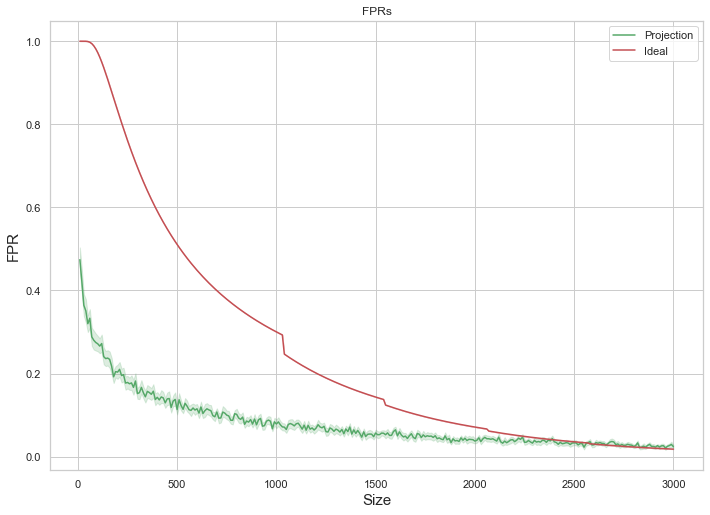

In [17]:
sns.set(rc={'figure.figsize':(11.7,8.27)},style="whitegrid")
sns.lineplot(x=size_values, y=fpr_values, err_style="band",label = "Projection",linewidth = 1.5,color="g")
sns.lineplot(x=size_values, y=y_ideal, err_style="band",label = "Ideal",linewidth = 1.5,color="r")
plt.title('FPRs')
plt.xlabel("Size", fontsize = 15)
plt.ylabel("FPR", fontsize = 15)
#plt.figure(figsize = (5000,5000))
plt.show()

In [18]:
average_fprs = num_of_iterations*average_fprs
print(len(average_fprs))

15000


In [19]:
average_times = num_of_iterations*average_times
print(len(average_times))

15000


In [20]:
print(average_fprs)

[0.47415094339622643, 0.42150943396226415, 0.3643396226415095, 0.35094339622641507, 0.32, 0.3332075471698112, 0.28830188679245283, 0.28018867924528307, 0.2749056603773585, 0.2716981132075472, 0.26622641509433964, 0.27226415094339623, 0.24094339622641514, 0.23603773584905657, 0.23735849056603772, 0.23415094339622644, 0.2177358490566038, 0.19226415094339624, 0.20471698113207548, 0.2035849056603773, 0.21018867924528306, 0.19528301886792454, 0.19735849056603771, 0.17716981132075474, 0.17867924528301887, 0.17547169811320756, 0.17754716981132074, 0.16679245283018868, 0.1820754716981133, 0.15188679245283018, 0.15415094339622645, 0.16679245283018865, 0.15377358490566043, 0.14415094339622642, 0.15716981132075472, 0.1543396226415095, 0.15018867924528306, 0.15754716981132078, 0.13754716981132076, 0.14283018867924532, 0.13660377358490566, 0.1437735849056604, 0.1415094339622642, 0.129622641509434, 0.13905660377358497, 0.14000000000000004, 0.11849056603773586, 0.13377358490566035, 0.1379245283018869

In [22]:
saved_data = list(zip(size_values, y_ideal, standard_times, average_standard_times, fpr_values, average_fprs, times, average_times))
df = pd.DataFrame(saved_data,columns = ['Size of filter(bits)','Ideal FPR','Standard Filter Total Creation Time(sec)', 'Average Standard Filter Total Creation Time(sec)', 'Projection FPR for iteration', 'Average Projection FPR', 'Projection Filter Total Creation Time(sec)', 'Average Projection Filter Total Creation Time(sec)'])
df.head()

,Size of filter(bits),Ideal FPR,Standard Filter Total Creation Time(sec),Average Standard Filter Total Creation Time(sec),Projection FPR for iteration,Average Projection FPR,Projection Filter Total Creation Time(sec),Average Projection Filter Total Creation Time(sec)
0,10,1.000000,0.003328,0.005363,0.311321,0.486792,0.279084,0.268647
1,20,1.000000,0.003875,0.004568,0.452830,0.396226,0.242433,0.261797
2,30,0.999994,0.007434,0.006548,0.339623,0.316981,0.212526,0.256144
3,40,0.999881,0.004049,0.005403,0.283019,0.258491,0.212213,0.244529
4,50,0.999263,0.004847,0.004823,0.358491,0.288679,0.290663,0.260454


In [23]:
df.to_csv('/Users/aditijain/Desktop/NewFolderWithItems/SURA/BreastCancer_rerun_epochs_100.csv')